In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_rs_df, load_ver_df

# Load data


In [2]:
RS_PATH = "../data/evaluation/random_search"

rs_df = load_rs_df(RS_PATH)

scenario_df = load_scenario_df("../data/definition/rs_routes.xml")

rs_df = rs_df.join(scenario_df, on='route_index', how='inner').sort_index()

# verification set is becoming a
ver_df = load_ver_df(RS_PATH + "/rs_v3/verification").set_index(
    'route_id')

## Load model


In [3]:

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

/home/olek/.miniconda3/envs/data-science/lib/python3.12/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.4.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# PROCESS DATA


## Predict fidelity robustness


In [4]:
def do_prediction(rs_trace: pd.DataFrame, model, features=['max_angles', 'dist_len_ratio', 'n_turns']) -> pd.DataFrame:
    X = rs_trace[features].to_numpy()
    rs_trace['prediciton'] = model.predict(X)
    return rs_trace

# rs_trace = do_prediction(rs_trace, model)
# rs_trace['prediciton'].value_counts()

**! very important here**
Here in 10FPS epic we have deemed 64 safe runs so they will be using low fid.
The rest of risky scenarios (686) will use high fidelity


to substitute running for risky scenario swap with 20Fid executions which is in verification set


## Fuse fidelities


In [5]:
def do_fidelity_fusion(rs_trace):
    # makes sense in case of classifier
    processed_batches = []

    # iterate over prediction classes
    for prediciton, batch in rs_trace.groupby('prediciton'):
        match prediciton:
            case 'safe':
                # do nothihg if scenario is safe to run
                batch['swapped'] = 'no'
                pass
            case 'risky':

                # use verification data set as high fidelity
                high_fid = ver_df

                # if scenario is risky swap with HF data from verification set
                high_fid = high_fid[['driving_score', 'duration_system']]
                batch = batch.drop(
                    ['driving_score', 'duration_system'], axis=1)
                batch = batch.join(high_fid, on='route_id')
                batch['swapped'] = 'yes'

        processed_batches.append(batch)

    mff_trace = pd.concat(processed_batches).sort_index()
    return mff_trace


# mff_trace = do_fidelity_fusion(rs_trace)

## Compute solutions of trace

random search


In [6]:
def get_solutions_of_iteration(rs_trace, curr_it):

    idx = pd.IndexSlice
    # get slice of data frame from iteration 0 to current iteration
    slice = rs_trace.loc[idx[:, :, :, :curr_it], :]

    # get index of minumum driving score -> solution (in iterations so far)
    gb = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score']

    solutions_idx = gb.idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = gb.min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

# get_solutions_of_iteration(mff_trace, 0)

In [7]:
def get_solutions_from_trace(rs_trace: pd.DataFrame) -> pd.DataFrame:

    NUM_OF_ITERAITONS = 25

    sols_df = pd.concat([get_solutions_of_iteration(rs_trace, it)
                        for it in range(NUM_OF_ITERAITONS)], axis=0)

    # at what iteration did we find the solution
    sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
    # what is the route_id of the solution
    sols_df['solution_route_id'] = sols_df['solution_idx'].apply(
        lambda x: x[-1])

    # we don't need that once unpacked
    # sols_df = sols_df.drop('solution_idx', axis=1)

    # add data from verification
    oracle_df = ver_df['driving_score'].rename("oracle_dscore")
    sols_df = sols_df.join(oracle_df, on='solution_route_id')
    sols_df = sols_df.sort_index()
    return sols_df


# mff_sols = get_solutions_from_trace(mff_trace)

## Add cumulative time


In [8]:
def get_cumulative_time_from_trace(rs_trace: pd.DataFrame) -> pd.Series:
    cumulative_time = (rs_trace['duration_system']
                       .groupby(['fps', 'highquality', 'rep'])
                       .cumsum()
                       .rename('cumulative_time'))

    return cumulative_time


# ct = get_cumulative_time_from_trace(mff_trace)
# mff_sols = mff_sols.join(ct)
# mff_sols

## Average repetitions for a smooth curve


In [9]:
def average_repetitions(sols_df: pd.DataFrame):

    return (sols_df
            .select_dtypes('number')
            .groupby(['fps', 'highquality', 'it'])
            .mean())

# mff_sols = average_repetitions(mff_sols)

# MULTIFIDELITY FUSION


## Predict fidelity robustness


In [ ]:
def do_prediction(rs_trace: pd.DataFrame, model, features=['max_angles', 'dist_len_ratio', 'n_turns']) -> pd.DataFrame:
    X = rs_trace[features].to_numpy()
    rs_trace['prediciton'] = model.predict(X)
    return rs_trace

# rs_trace = do_prediction(rs_trace, model)
# rs_trace['prediciton'].value_counts()

**! very important here**
Here in 10FPS epic we have deemed 64 safe runs so they will be using low fid.
The rest of risky scenarios (686) will use high fidelity


to substitute running for risky scenario swap with 20Fid executions which is in verification set


## Fuse fidelities


In [ ]:
def do_fidelity_fusion(rs_trace):
    # makes sense in case of classifier
    processed_batches = []

    # iterate over prediction classes
    for prediciton, batch in rs_trace.groupby('prediciton'):
        match prediciton:
            case 'safe':
                # do nothihg if scenario is safe to run
                batch['swapped'] = 'no'
                pass
            case 'risky':

                # use verification data set as high fidelity
                high_fid = ver_df

                # if scenario is risky swap with HF data from verification set
                high_fid = high_fid[['driving_score', 'duration_system']]
                batch = batch.drop(
                    ['driving_score', 'duration_system'], axis=1)
                batch = batch.join(high_fid, on='route_id')
                batch['swapped'] = 'yes'

        processed_batches.append(batch)

    mff_trace = pd.concat(processed_batches).sort_index()
    return mff_trace


# mff_trace = do_fidelity_fusion(rs_trace)

## Simulate MFF traces


In [10]:
def simulate_mff_traces(traces):
    lowfid_traces = traces.copy().xs(("10", "True"), drop_level=False).sort_index()
    lowfid_traces = do_prediction(lowfid_traces, model)
    mff_traces = do_fidelity_fusion(lowfid_traces)
    return mff_traces

## Process search traces


In [11]:
def process_traces(traces, avg=True):

    # get solutions at each iterations
    sols_df = get_solutions_from_trace(traces)

    # calculate cumulative time of iterations
    cumulative_time = get_cumulative_time_from_trace(traces)
    sols_df = sols_df.join(cumulative_time)

    # average repetitions
    if avg:
        sols_df = average_repetitions(sols_df)

    return sols_df

# MAIN


In [12]:
# MAIN
rs_traces = rs_df.reset_index().set_index(
    ['fps', 'highquality', 'rep', 'it', 'route_id'])

old_sols = process_traces(rs_traces)
# do the same for mff
mff_traces = simulate_mff_traces(rs_traces)
mff_sols = process_traces(mff_traces)

# PLOT


## Old solutions


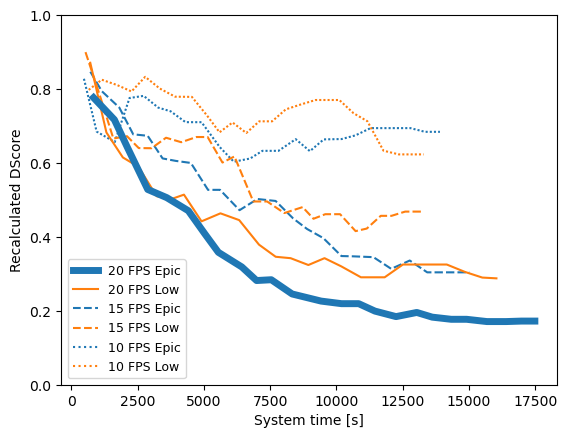

In [13]:
def plot_solutions(sols_df):

    # let 20FPS be first
    sols_df = sols_df.sort_index(ascending=False)
    f, ax = plt.subplots()

    sns.lineplot(data=sols_df, x='cumulative_time', y='oracle_dscore',
                 style='fps', hue='highquality', ax=ax, errorbar=None)

    sns.lineplot(data=sols_df.xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
                 y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)

    ax.set_ylabel("Recalculated DScore")
    ax.set_xlabel("System time [s]")
    ax.set_ylim(0, 1)

    # BETTER LEGEND
    handles, labels = ax.get_legend_handles_labels()

    blue = handles[1].get_color()
    orange = handles[2].get_color()
    lines = [
        mlines.Line2D([], [], color=blue, linestyle=None,
                      label='20 FPS Epic', lw=5),
        mlines.Line2D([], [], color=orange,
                      linestyle=None, label='20 FPS Low'),

        mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='--', label='15 FPS Low'),
        mlines.Line2D([], [], color=blue, linestyle='dotted',
                      label='10 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='dotted', label='10 FPS Low'),

    ]

    ax.legend(handles=lines, prop={'size': 9})

    # f.savefig('plot_rq3.pdf', bbox_inches='tight')


plot_solutions(old_sols)

## Plot mff


[]


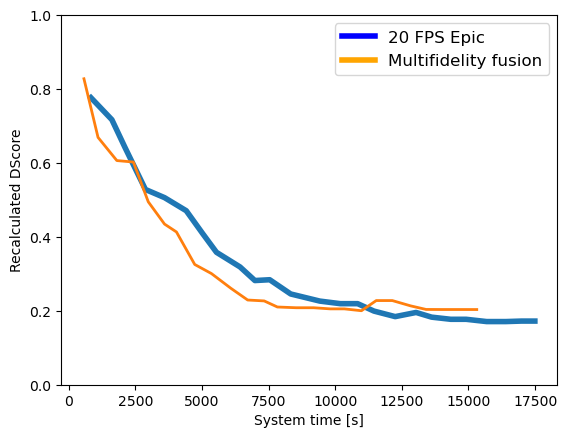

In [14]:
def plot_mff(baseline, mff_sols):

    f, ax = plt.subplots()
    sns.lineplot(data=baseline,  x='cumulative_time',
                 y='oracle_dscore', ax=ax,  errorbar=None, lw=4)

    sns.lineplot(data=mff_sols,  x='cumulative_time',
                 y='oracle_dscore', ax=ax,  errorbar=None, lw=2)

    ax.set_ylabel("Recalculated DScore")
    ax.set_xlabel("System time [s]")
    ax.set_ylim(0, 1)
    handles, labels = ax.get_legend_handles_labels()
    print(handles)

    # blue = handles[0].get_color()
    # orange = handles[0].get_color()

    lines = [
        mlines.Line2D([], [], color="blue", lw=4,
                      label='20 FPS Epic'),
        mlines.Line2D([], [], color="orange", lw=4,

                      label='Multifidelity fusion'),
    ]
    ax.legend(handles=lines, prop={'size': 12})
    f.savefig('plot.pdf', bbox_inches='tight')


plot_mff(baseline=old_sols.xs(("20", "True")), mff_sols=mff_sols)

# Statistical tests


In [15]:
from scipy.stats import mannwhitneyu
from itertools import permutations

In [16]:

col = 'cumulative_time'
col = 'oracle_dscore'

old_sols_raw = process_traces(rs_traces, avg=False)
mff_sols_raw = process_traces(mff_traces, avg=False)

hf_sols_raw = old_sols_raw.xs(("20", "True"))


def to_list(sols_df: pd.DataFrame, column: str) -> pd.Series:
    return sols_df[column].groupby('it').agg(list)

In [17]:
def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.99):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\t The difference beetween {fid_a} and {fid_b} IS statistically significant. {p=:.5f}")
        # print(set_a)
        # print(set_b)
    else:
        # return
        print(
            f"\t The difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p=:.5f}")

In [18]:
print(f'Doing statisical tests for {col}:')
for it, (mf, hf) in enumerate(zip(to_list(mff_sols_raw, col), to_list(hf_sols_raw, col))):
    print(f"At {it=} ", end='')
    do_test("MFF", "High fid", mf, hf)

Doing statisical tests for oracle_dscore:
At it=0 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.22927
At it=1 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.94466
At it=2 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.88617
At it=3 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.39143
At it=4 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.67186
At it=5 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.34204
At it=6 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.52389
At it=7 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.26713
At it=8 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.45960
At it=9 	 The difference beetween MFF and High fid is NOT statistically significant. p=0.25172
At it=10